In [3]:
!pip install igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.0 MB/s eta 0:00:00


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import mmread
import random
import pandas as pd
import community as community_louvain
from networkx.algorithms.centrality import betweenness_centrality
from networkx.algorithms.centrality import current_flow_closeness_centrality
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.linalg import eigh
import numpy as np

# 1. Explore and describe the data

In [2]:
# Load the Matrix Market file
matrix_path = "/content/socfb-Texas84.mtx"
adjacency_matrix = mmread(matrix_path).tocoo()
# Convert to a NetworkX graph
G = nx.Graph()
G.add_edges_from(zip(adjacency_matrix.row, adjacency_matrix.col))

# Print basic information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Sample edges:")
print(list(G.edges())[:10])  # show first 10 edge


Number of nodes: 36364
Number of edges: 1590651
Sample edges:
[(np.int32(392), np.int32(0)), (np.int32(392), np.int32(118)), (np.int32(392), np.int32(230)), (np.int32(392), np.int32(554)), (np.int32(392), np.int32(563)), (np.int32(392), np.int32(573)), (np.int32(392), np.int32(736)), (np.int32(392), np.int32(752)), (np.int32(392), np.int32(859)), (np.int32(392), np.int32(938))]


### Visualize the Graph

<ipython-input-4-ebd33c275aeb>:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


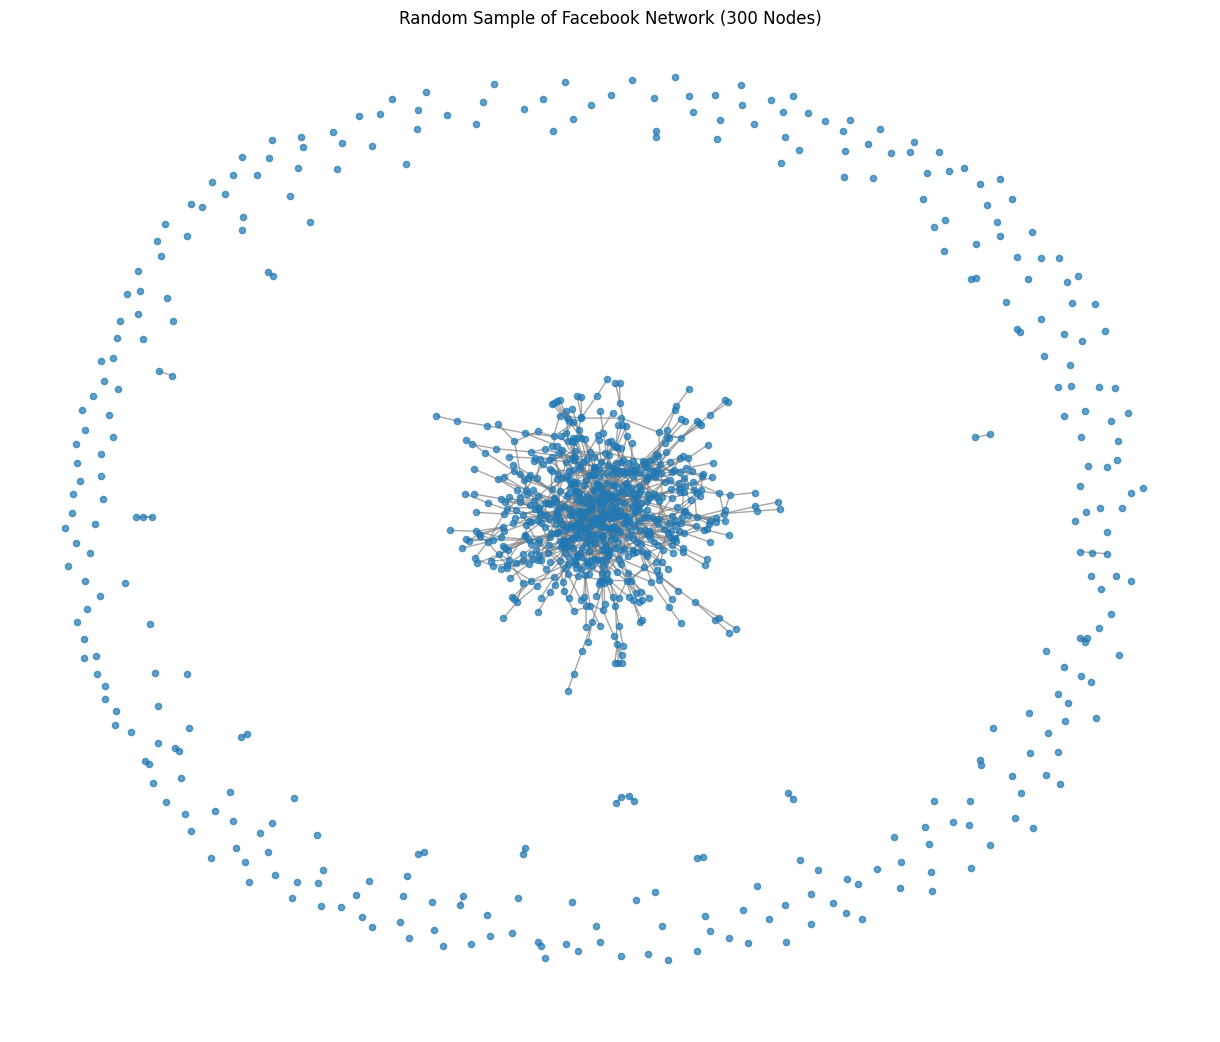

In [4]:
import random

# Sample a subset of nodes (e.g., 300) and create a subgraph
sample_nodes = random.sample(list(G.nodes()), 1000)

subgraph = G.subgraph(sample_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, node_size=20, edge_color='gray', alpha=0.7)
plt.title("Random Sample of Facebook Network (300 Nodes)")
plt.tight_layout()
# plt.savefig("../outputs/sample_graph_plot.png", dpi=300)
plt.show()

### Compute Centrality Measures with random sampling

In [5]:
# Sample a smaller subgraph
sample_nodes = random.sample(list(G.nodes()), 2000)
G_small = G.subgraph(sample_nodes).copy()

# Compute centrality measures on the smaller graph
degree_centrality = nx.degree_centrality(G_small)
closeness_centrality = nx.closeness_centrality(G_small)
betweenness_centrality = nx.betweenness_centrality(G_small, k=100, seed=42)

# Convert to DataFrame
centrality_df = pd.DataFrame({
    "node": list(degree_centrality.keys()),
    "degree": list(degree_centrality.values()),
    "closeness": list(closeness_centrality.values()),
    "betweenness": list(betweenness_centrality.values())
})

# Sort and display top 10 by each
top_degree = centrality_df.sort_values("degree", ascending=False).head(10)
top_closeness = centrality_df.sort_values("closeness", ascending=False).head(10)
top_betweenness = centrality_df.sort_values("betweenness", ascending=False).head(10)

print("Top 10 by Degree Centrality:")
print(top_degree)

print("\nTop 10 by Closeness Centrality:")
print(top_closeness)

print("\nTop 10 by Betweenness Centrality:")
print(top_betweenness)


Top 10 by Degree Centrality:
       node    degree  closeness  betweenness
1732  15096  0.033517   0.277218     0.041250
171   17049  0.025513   0.264984     0.056331
1110  28804  0.023012   0.262625     0.030274
1992   8154  0.022511   0.264881     0.030765
71    24885  0.020510   0.256373     0.014356
495    1959  0.020510   0.261159     0.027639
246     961  0.018009   0.258571     0.014709
1017  20226  0.016508   0.255408     0.015344
1918   7736  0.016008   0.257933     0.014553
401   34347  0.015008   0.256083     0.024445

Top 10 by Closeness Centrality:
       node    degree  closeness  betweenness
1732  15096  0.033517   0.277218     0.041250
171   17049  0.025513   0.264984     0.056331
1992   8154  0.022511   0.264881     0.030765
1110  28804  0.023012   0.262625     0.030274
495    1959  0.020510   0.261159     0.027639
1086  28704  0.011006   0.259115     0.009824
246     961  0.018009   0.258571     0.014709
1918   7736  0.016008   0.257933     0.014553
459   34611  0.013

### Compute Centrality Measures with specific Top 5% Key Nodes

In [6]:
# ================ Top 5% Key Nodes Analysis ================
def analyze_top_percent(G, percentile=0.05, neighbor_sample=3):
    """
    Analyze top X% influential nodes and their community structure

    Args:
        G (NetworkX Graph): Input graph
        percentile (float): Top percentage to analyze (default: 0.05 for top 5%)
        neighbor_sample (int): Number of neighbors to sample per key node
    """
    if not G or G.number_of_nodes() == 0:
        print("Empty graph, skipping analysis")
        return

    # --- Step 1: Identify top nodes by degree centrality ---
    print("\n[New Analysis] Calculating full graph degree centrality...")
    deg_cent = nx.degree_centrality(G)
    df_deg = pd.DataFrame(deg_cent.items(), columns=['node', 'degree_centrality'])
    top_count = int(percentile * len(df_deg))
    top_nodes = df_deg.nlargest(top_count, 'degree_centrality')['node'].tolist()

    # --- Step 2: Create subgraph of key nodes ---
    G_top = G.subgraph(top_nodes).copy()

    # --- Step 3: Calculate centrality metrics on subgraph ---
    print("[New Analysis] Computing centrality on key subgraph...")
    # Current-flow closeness centrality
    from networkx.algorithms.centrality import current_flow_closeness_centrality
    cfcc_top = current_flow_closeness_centrality(G_top)
    df_cfcc = pd.DataFrame(cfcc_top.items(), columns=['node', 'closeness_centrality'])

    # Betweenness centrality (approximate)
    from networkx.algorithms.centrality import betweenness_centrality
    bet_cent_top = betweenness_centrality(G_top, k=100, seed=42)
    df_bet = pd.DataFrame(bet_cent_top.items(), columns=['node', 'betweenness_centrality'])

    # --- Merge all centrality results ---
    merged_df = df_deg.merge(df_cfcc, on='node').merge(df_bet, on='node')

    # --- Display results ---
    print(f"\n[Degree Centrality] Top 5 nodes:")
    print(merged_df.sort_values('degree_centrality', ascending=False).head(5))

    print(f"\n[Closeness Centrality] Top 5 nodes:")
    print(merged_df.sort_values('closeness_centrality', ascending=False).head(5))

    print(f"\n[Betweenness Centrality] Top 5 nodes:")
    print(merged_df.sort_values('betweenness_centrality', ascending=False).head(5))

    # --- Visualize key nodes with neighbors ---
    print("\n[New Analysis] Visualizing key nodes...")
    partial_neighbors = set()
    for node in top_nodes:
        neighbors = list(G.neighbors(node))
        sampled = random.sample(neighbors, min(neighbor_sample, len(neighbors)))
        partial_neighbors.update(sampled)
    sub_nodes = set(top_nodes) | partial_neighbors
    subgraph = G.subgraph(sub_nodes)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, seed=42)
    node_colors = ['red' if n in top_nodes else 'lightblue' for n in subgraph.nodes()]
    nx.draw(subgraph, pos, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7)
    plt.title(f"Top {percentile*100}% Influencers with Neighbors")
    plt.show()

    return subgraph



=== New Analysis Module ===

[New Analysis] Calculating full graph degree centrality...
[New Analysis] Computing centrality on key subgraph...

[Degree Centrality] Top 5 nodes:
      node  degree_centrality  closeness_centrality  betweenness_centrality
303  15322           0.173583              0.042673                0.022184
12   16949           0.151858              0.043059                0.039759
285  17255           0.131617              0.040057                0.010374
413  16525           0.088249              0.040192                0.013306
96   31303           0.067816              0.040791                0.014899

[Closeness Centrality] Top 5 nodes:
      node  degree_centrality  closeness_centrality  betweenness_centrality
12   16949           0.151858              0.043059                0.039759
303  15322           0.173583              0.042673                0.022184
96   31303           0.067816              0.040791                0.014899
157  26681           0.0

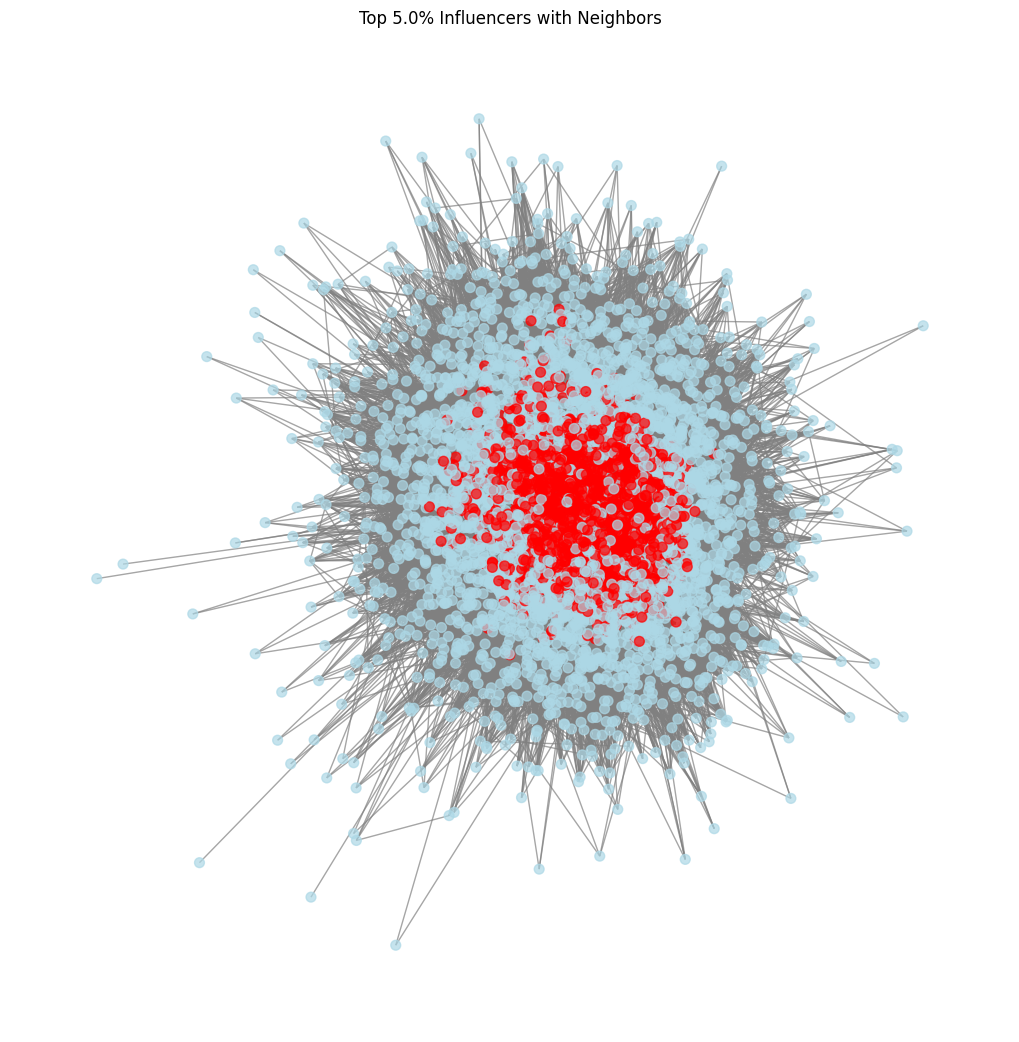

In [7]:
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc)

# Execute analysis (using original graph's LCC)
print("\n\n=== New Analysis Module ===")
subgraph_top5 = analyze_top_percent(G_lcc)

### Visualizing Centrality Comparisons

<ipython-input-8-0eb94f8eae6d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="node", x="degree", data=top_degree, palette="Blues_d")
<ipython-input-8-0eb94f8eae6d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="node", x="closeness", data=top_closeness, palette="Greens_d")
<ipython-input-8-0eb94f8eae6d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="node", x="betweenness", data=top_betweenness, palette="Reds_d")


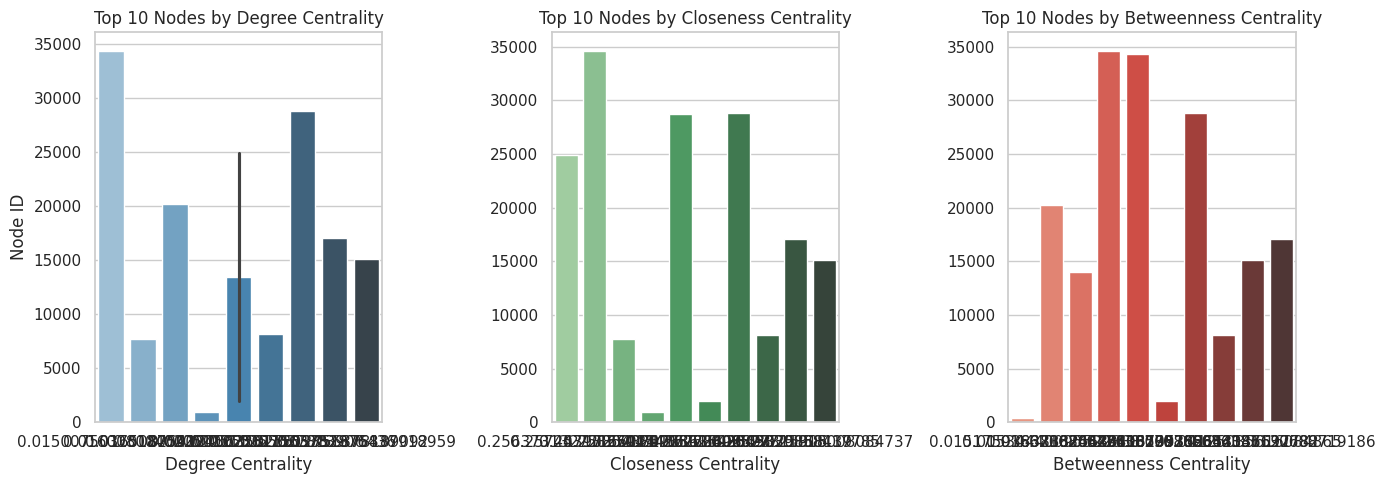

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))

# Degree centrality plot
plt.subplot(1, 3, 1)
sns.barplot(y="node", x="degree", data=top_degree, palette="Blues_d")
plt.title("Top 10 Nodes by Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Node ID")

# Closeness centrality plot
plt.subplot(1, 3, 2)
sns.barplot(y="node", x="closeness", data=top_closeness, palette="Greens_d")
plt.title("Top 10 Nodes by Closeness Centrality")
plt.xlabel("Closeness Centrality")
plt.ylabel("")

# Betweenness centrality plot
plt.subplot(1, 3, 3)
sns.barplot(y="node", x="betweenness", data=top_betweenness, palette="Reds_d")
plt.title("Top 10 Nodes by Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("")

plt.tight_layout()
# plt.savefig("../outputs/centrality_comparison.png", dpi=300)
plt.show()


# 2. Community Detection

### Algo1 Spectral Clustering

<ipython-input-9-71933c487805>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


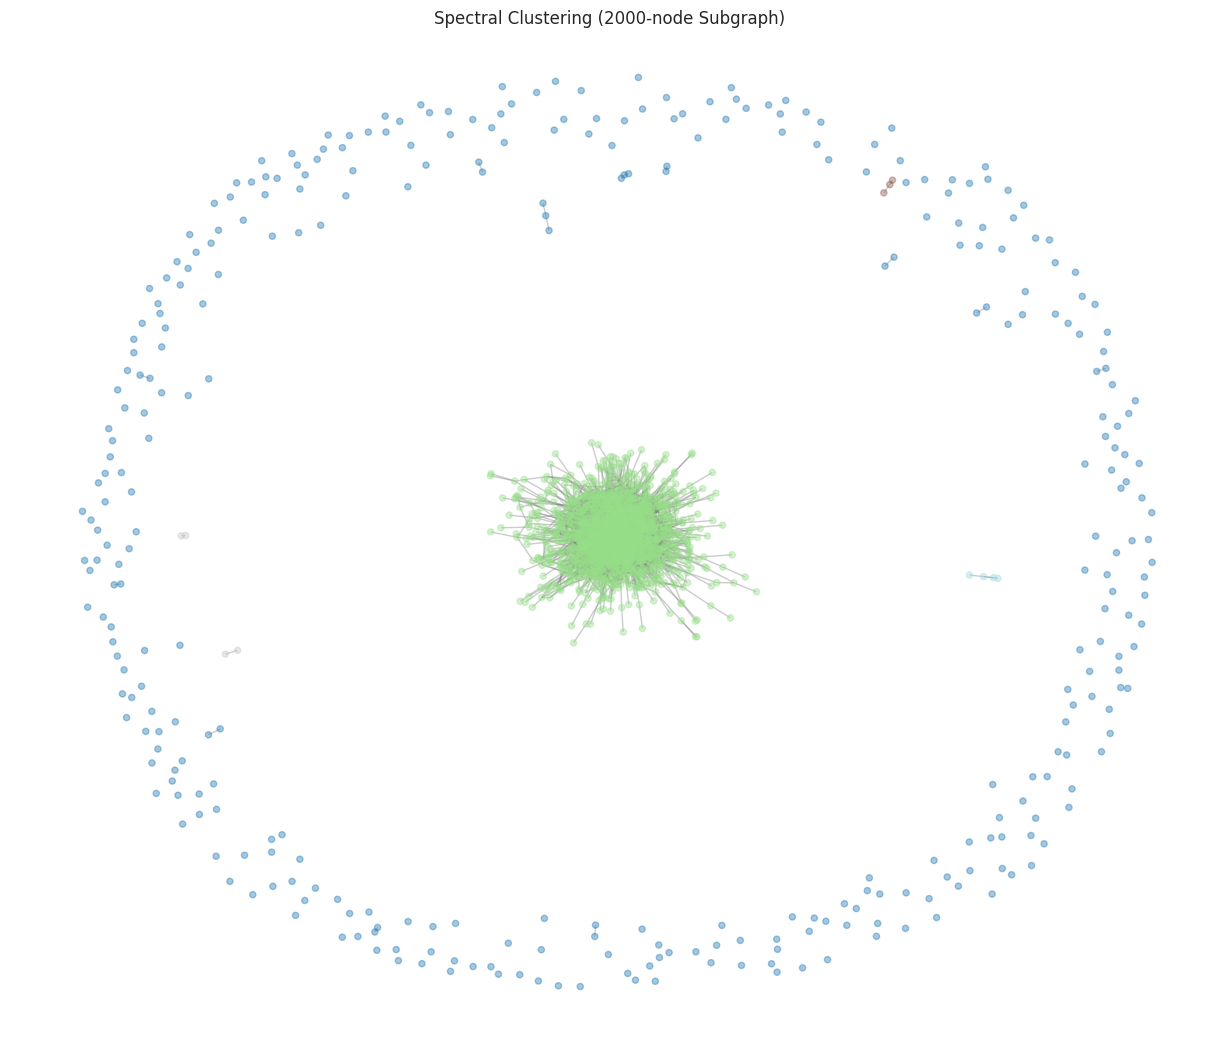

In [9]:


# Step 1: Build Adjacency and Laplacian Matrices
A = nx.to_numpy_array(G_small)
D = np.diag(np.sum(A, axis=1))
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1) + 1e-10))
L = np.eye(len(G_small)) - D_inv_sqrt @ A @ D_inv_sqrt

# Step 2: Eigen Decomposition using stable solver
eigvals, eigvecs = eigh(L)
k = 5  # Number of communities
eigvecs = eigvecs[:, :k]

# Normalize and Cluster
X = normalize(eigvecs)
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)


# Step 4: Map labels to nodes
node_list = list(G_small.nodes())
spectral_map = dict(zip(node_list, labels))

# Add to DataFrame if useful later
centrality_df["spectral_cluster"] = centrality_df["node"].map(spectral_map)

# Visualization
colors = [spectral_map[n] % 20 for n in node_list]
pos = nx.spring_layout(G_small, seed=42)

plt.figure(figsize=(12, 10))
nx.draw(G_small, pos, node_color=colors, cmap=plt.cm.tab20, node_size=20, edge_color='gray', alpha=0.4)
plt.title("Spectral Clustering (2000-node Subgraph)")
plt.axis('off')
plt.tight_layout()
# plt.savefig("../outputs/spectral_clustering_2000.png", dpi=300)
plt.show()



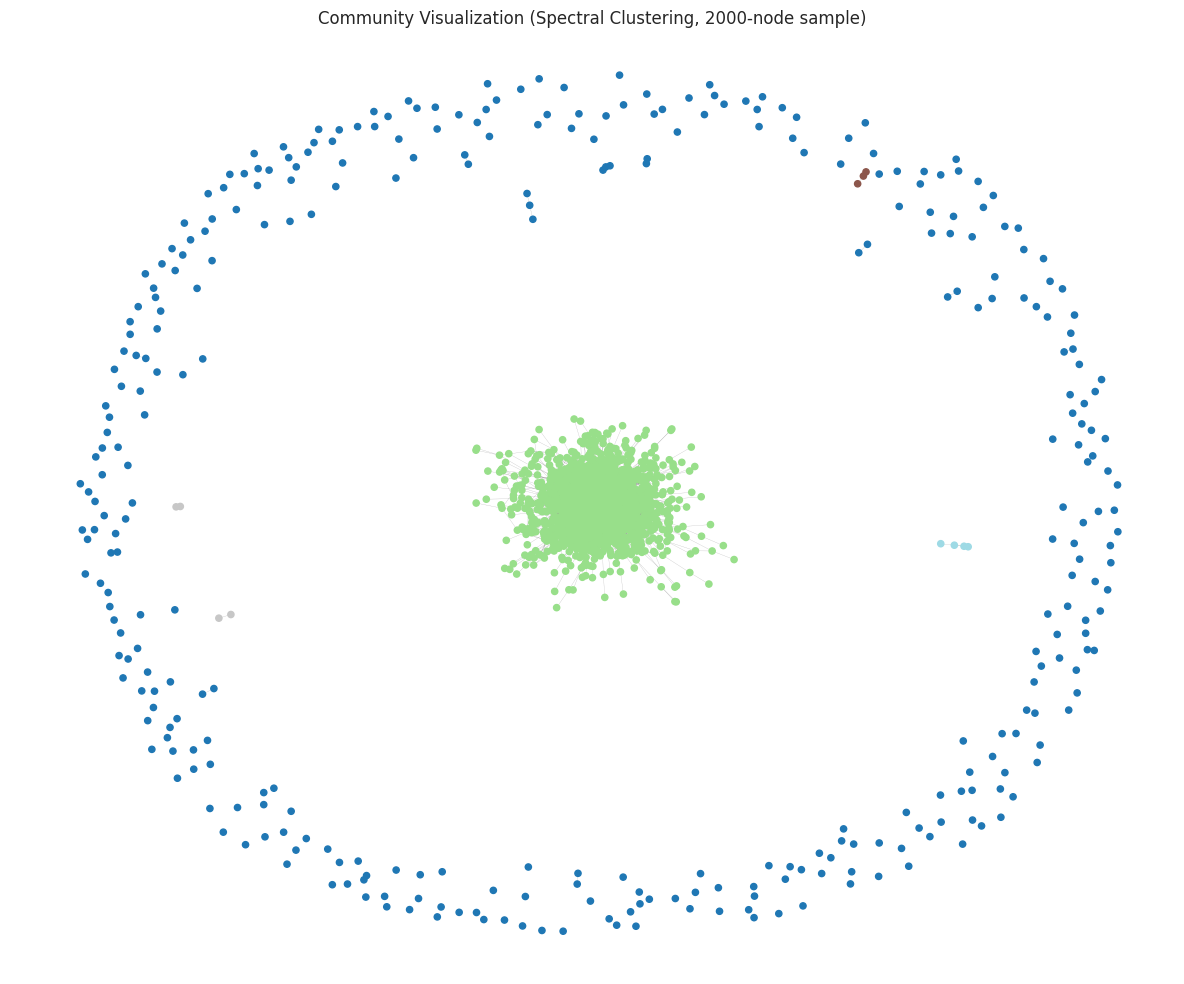

In [10]:
import matplotlib.pyplot as plt

# Layout for drawing (reuse same layout for consistency)
pos = nx.spring_layout(G_small, seed=42)

# Get list of nodes in G_small
nodes = list(G_small.nodes())

# Filter centrality_df to include only nodes in G_small
centrality_subset = centrality_df[centrality_df["node"].isin(nodes)]

# Ensure the mapping aligns with node order
spectral_colors = centrality_subset.set_index("node").reindex(nodes)["spectral_cluster"].map(lambda x: x % 20)

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_small, pos, node_color=spectral_colors, cmap=plt.cm.tab20, node_size=20)
nx.draw_networkx_edges(G_small, pos, alpha=0.3, width=0.2)
plt.title("Community Visualization (Spectral Clustering, 2000-node sample)")
plt.axis('off')
plt.tight_layout()
# plt.savefig("../outputs/spectral_clustering_visualization.png", dpi=300)
plt.show()


In [11]:
centrality_df["spectral_cluster"].value_counts()


spectral_cluster
1    1648
0     341
3       4
4       4
2       3
Name: count, dtype: int64

### Algo2 girvan_newman

Girvan-Newman: Found 333 communities at first split.


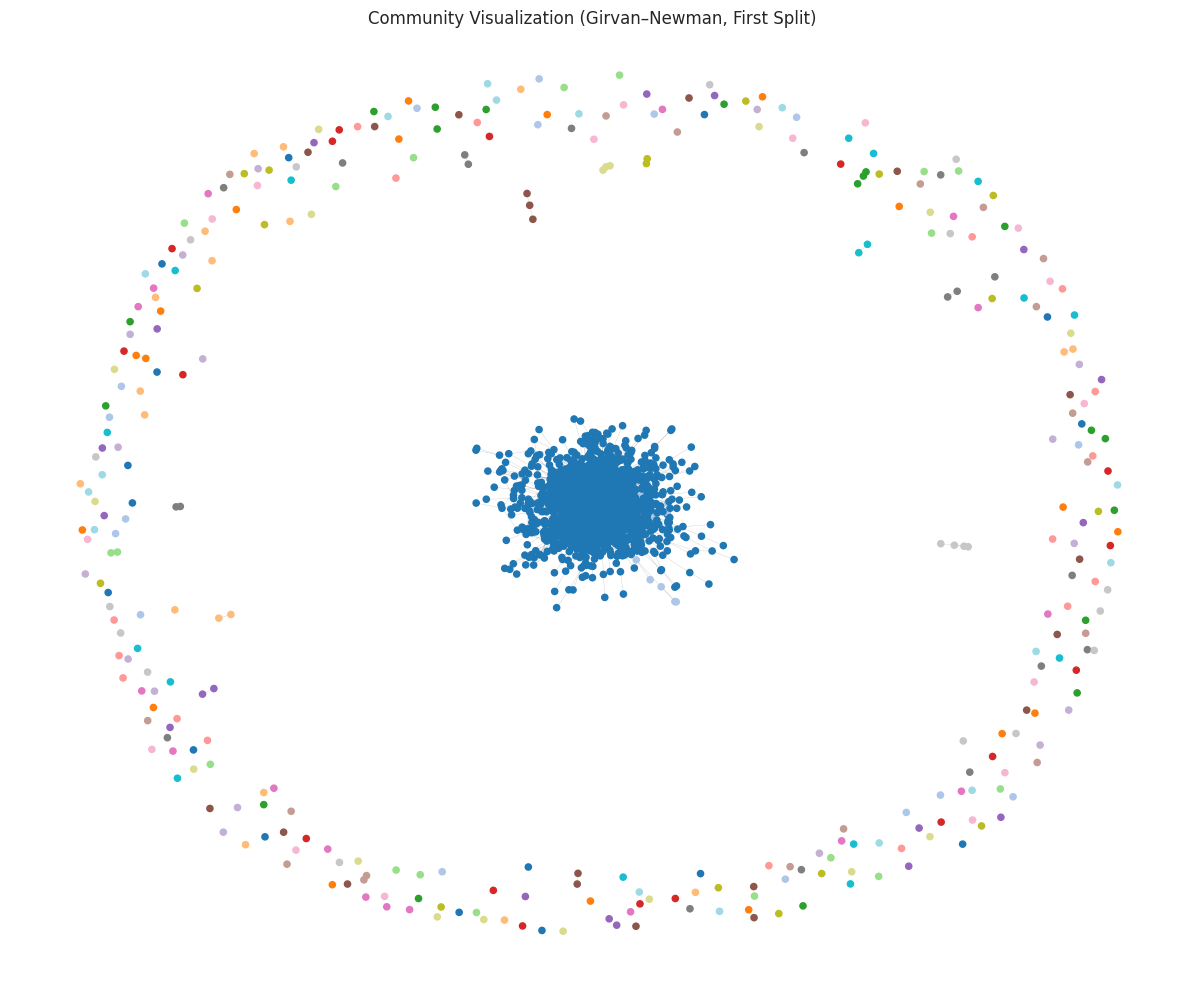

In [12]:
from networkx.algorithms.community import girvan_newman

# Applying Girvan-Newman to get first-level communities
gn_generator = girvan_newman(G_small)
gn_communities = next(gn_generator)  # First split only
gn_communities = [list(c) for c in gn_communities]

print(f"Girvan-Newman: Found {len(gn_communities)} communities at first split.")

# Assign community label to each node
gn_map = {}
for idx, community in enumerate(gn_communities):
    for node in community:
        gn_map[node] = idx

# Map node to community color (modulo 20 for color cycling)
gn_colors = centrality_df.set_index("node").index.map(lambda x: gn_map.get(x, -1) % 20)

# Visualize Girvan–Newman communities
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_small, pos, node_color=gn_colors, cmap=plt.cm.tab20, node_size=20)
nx.draw_networkx_edges(G_small, pos, alpha=0.3, width=0.2)
plt.title("Community Visualization (Girvan–Newman, First Split)")
plt.axis('off')
plt.tight_layout()
# plt.savefig("../outputs/gn_community_visualization.png", dpi=300)
plt.show()


### Attempt Louvain Algorithm and Label Propagation Algorithm

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

def draw_community_graph(G, community_map, title="Community Detection"):
    if not community_map or not G.nodes():
        print(f"can't plot '{title}': community_map is empty")
        return

    pos = nx.spring_layout(G, seed=42, k=0.1) # k is for density of graph

    communities = set(community_map.values())
    num_communities = len(communities)

    # diff colors for diff communities
    if num_communities <= 20:
        cmap = plt.get_cmap('tab20')
        node_colors = [cmap(community_map[n] % 20) for n in G.nodes()]
    else:
        # Generate colors for more than 20 communities (may be less distinct)
        colors_list = [plt.cm.hsv(i/num_communities) for i in range(num_communities)]
        # Create a mapping from community_id to a specific color
        community_to_color_map = {comm_id: colors_list[i] for i, comm_id in enumerate(sorted(list(communities)))}
        node_colors = [community_to_color_map[community_map[n]] for n in G.nodes()]


    plt.figure(figsize=(12, 12))
    nx.draw(
        G,
        pos=pos,
        node_color=node_colors,
        with_labels=False,
        node_size=30,
        edge_color='lightgray',
        width=0.5,
        alpha=0.7
    )
    plt.title(f"{title} - {num_communities} Communities", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

正在进行 Louvain 社区检测...


<ipython-input-24-403069c98b38>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


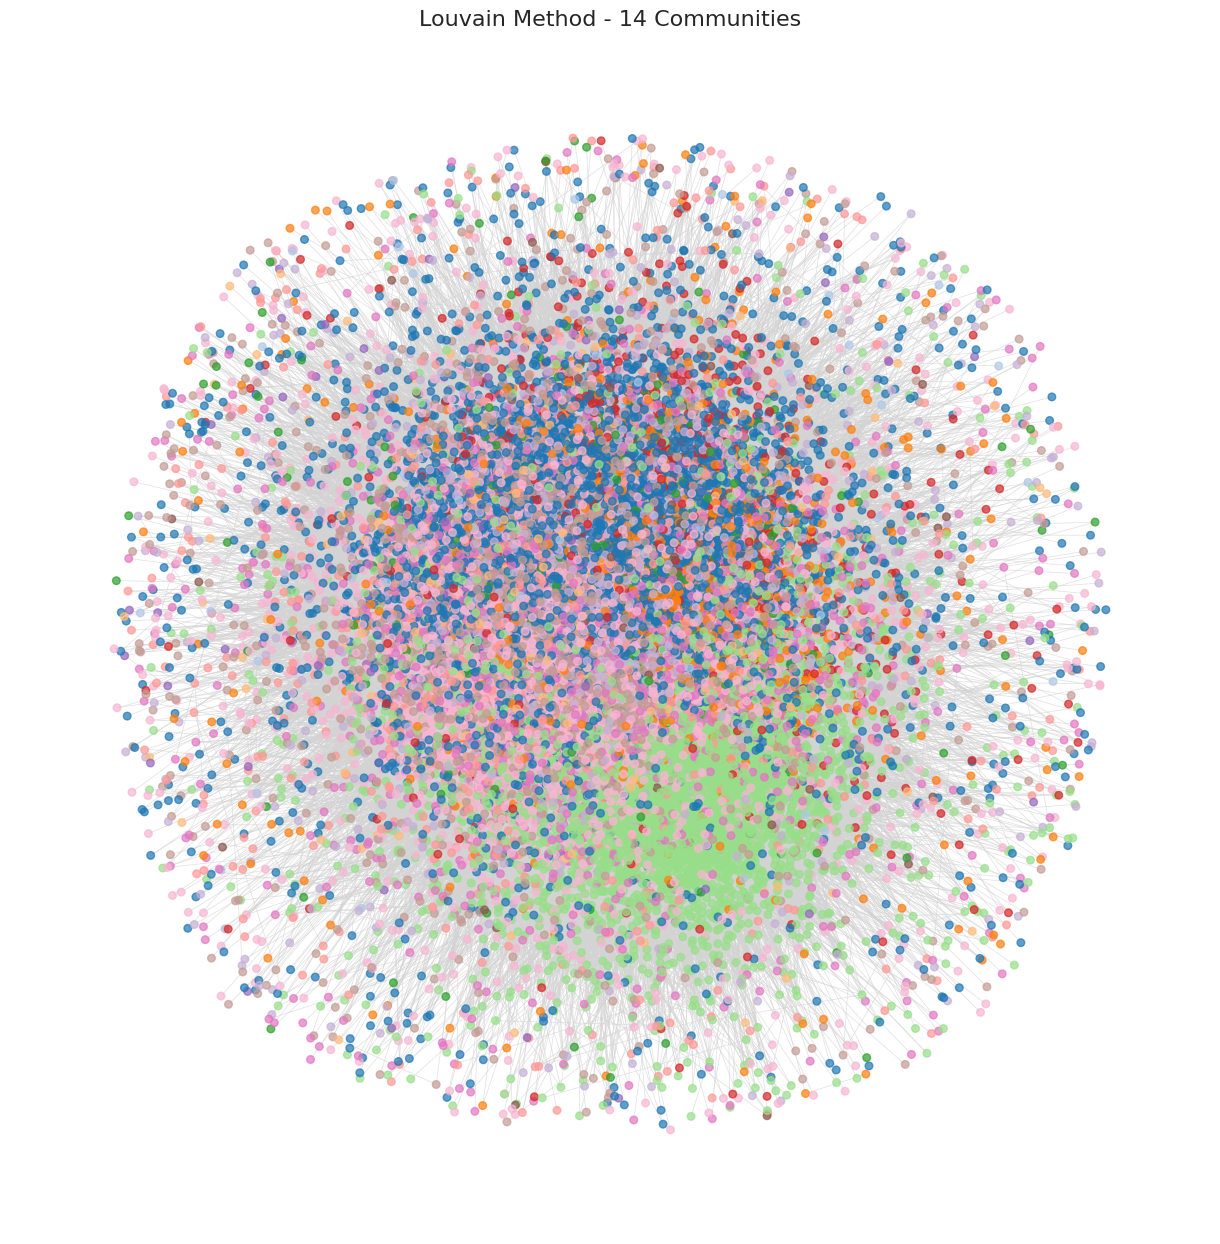

In [25]:
# detect on the whole graph
print("detecting Louvain commnities...")
partition_louvain = community_louvain.best_partition(G_lcc)
community_map_lv = partition_louvain
draw_community_graph(G_lcc, community_map_lv, title="Louvain Method")



正在进行 Label Propagation 社区检测...


<ipython-input-24-403069c98b38>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


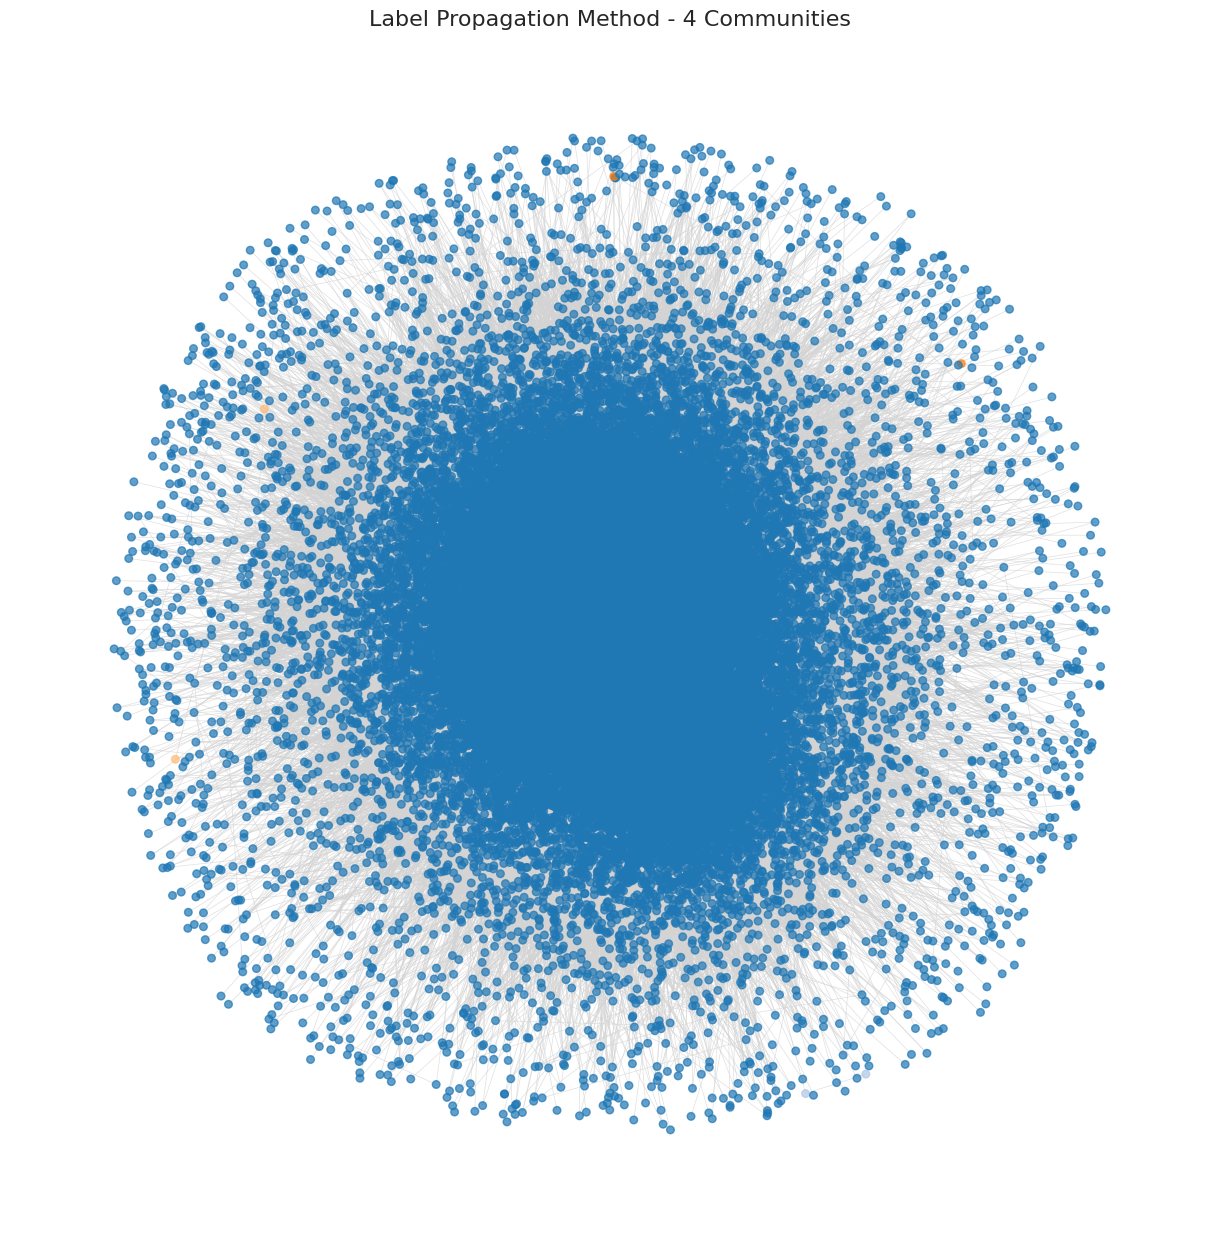

In [27]:
# -------------------- Label Propagation (LPA) communities detectation --------------------
if G_lcc and G_lcc.number_of_nodes() > 0: # make sure the graph is not empty
    print("\n detecting LPA community...")
    # LPA returns a generator, each element is a community (a set of nodes)
    communities_generator_lpa = nx.community.label_propagation_communities(G_lcc)
    lpa_communities_list = [list(c) for c in communities_generator_lpa]

    # Convert LPA's community list to community_map format
    community_map_lpa = {}
    for i, community in enumerate(lpa_communities_list):
        for node in community:
            community_map_lpa[node] = i

    if community_map_lpa:
        draw_community_graph(G_lcc, community_map_lpa, title="Label Propagation Method")
    else:
        print("Label Propagation failed to successfully divide the community or community_map_lpa is empty。")
else:
    print("The G_lcc graph is empty or undefined, skipping Label Propagation community detection.")


# 3. Identify the clique

Largest clique size: 7
Nodes in the largest clique: [np.int32(20919), np.int32(30334), np.int32(22854), np.int32(27859), np.int32(35604), np.int32(31070), np.int32(18155)]


<ipython-input-28-f5621e5699de>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


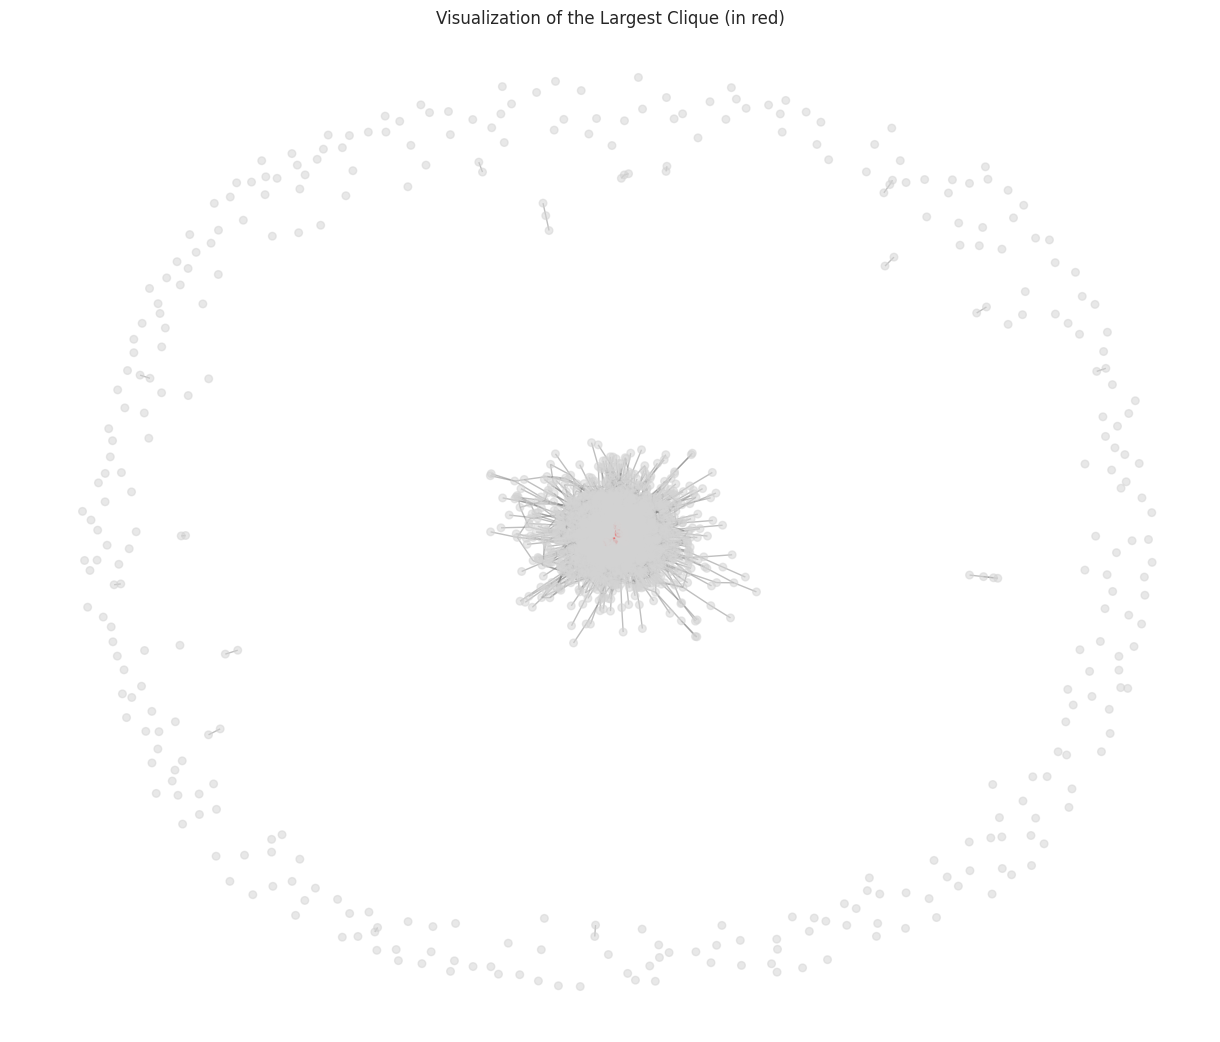

In [28]:
# Finding the largest clique
largest_clique = max(nx.find_cliques(G_small), key=len)
print(f"Largest clique size: {len(largest_clique)}")
print("Nodes in the largest clique:", largest_clique)

# Visualizing the clique in red, rest in gray
clique_nodes = set(largest_clique)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_small, seed=42)

# Color nodes
node_colors = ['red' if node in clique_nodes else 'lightgray' for node in G_small.nodes()]
nx.draw(G_small, pos, node_color=node_colors, node_size=30, edge_color='gray', alpha=0.5)

plt.title("Visualization of the Largest Clique (in red)")
plt.axis('off')
plt.tight_layout()
# plt.savefig("../outputs/largest_clique.png", dpi=300)
plt.show()


# 4. Filtering heavy hitters

Number of heavy hitters: 105
Sample heavy hitters:
      node    degree  closeness  betweenness  spectral_cluster
25  16507  0.007504   0.232918     0.003045                 1
62  16649  0.011006   0.239623     0.013989                 1
71  24885  0.020510   0.256373     0.014356                 1
78   8540  0.008004   0.222092     0.013513                 1
83    358  0.010505   0.245120     0.015176                 1


<ipython-input-29-a0706077a148>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


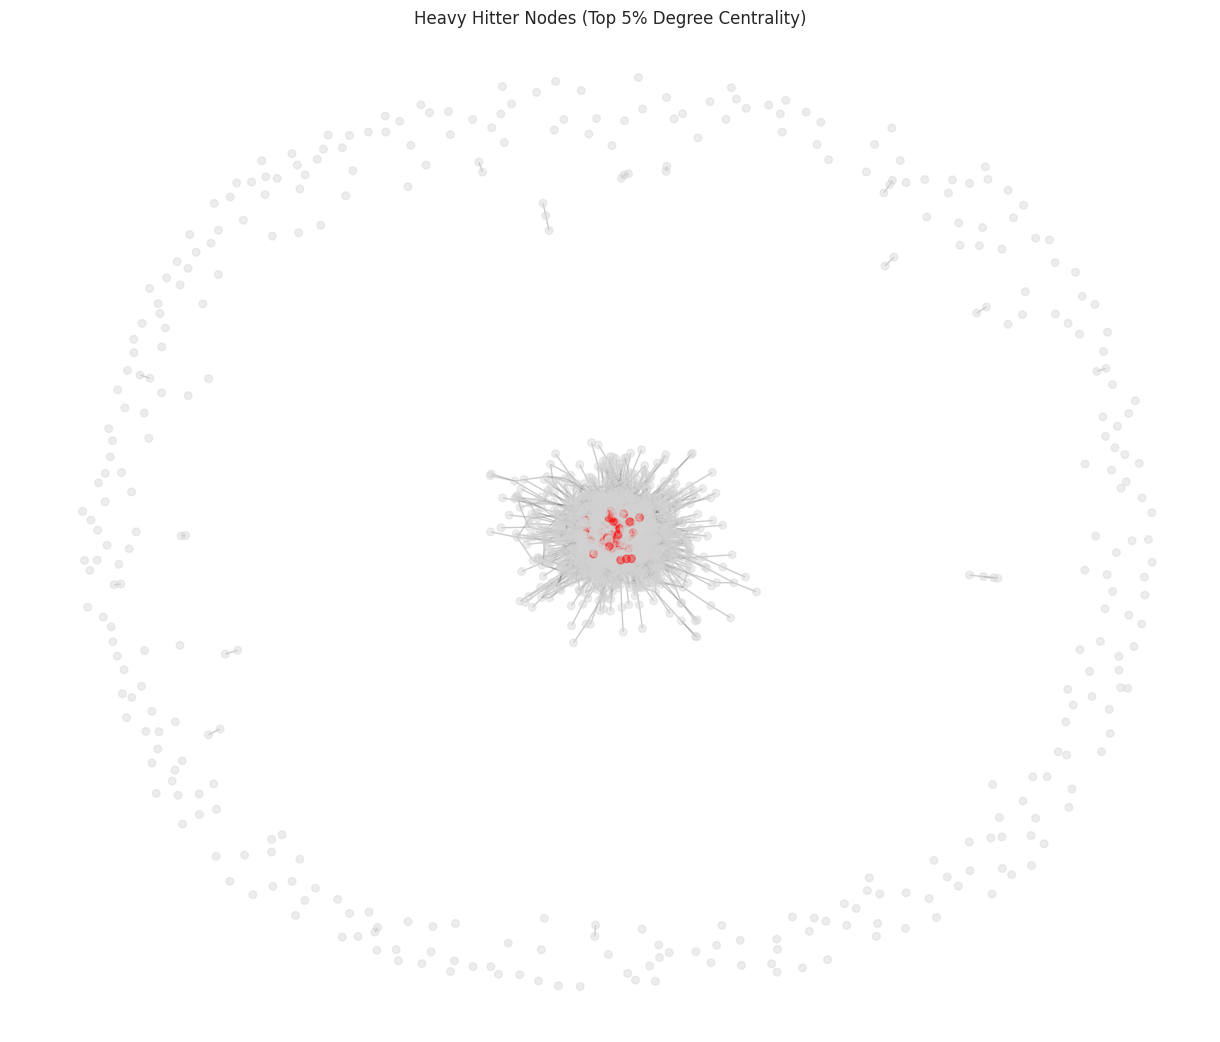

In [29]:
# Set threshold for top 5%
threshold = centrality_df["degree"].quantile(0.95)

# Filter heavy hitters
heavy_hitters = centrality_df[centrality_df["degree"] >= threshold]
print(f"Number of heavy hitters: {len(heavy_hitters)}")
print("Sample heavy hitters:\n", heavy_hitters.head())

# Visualize them in red on the full subgraph
hh_nodes = set(heavy_hitters["node"])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_small, seed=42)

node_colors = ['red' if node in hh_nodes else 'lightgray' for node in G_small.nodes()]
nx.draw(G_small, pos, node_color=node_colors, node_size=30, edge_color='gray', alpha=0.4)

plt.title("Heavy Hitter Nodes (Top 5% Degree Centrality)")
plt.axis('off')
plt.tight_layout()
# plt.savefig("../outputs/heavy_hitters.png", dpi=300)
plt.show()
